In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

### Read data and show some statistics

In [ ]:
solar_df = pd.read_csv("hessi.solar.flare.UP_To_2018.csv", sep=',', index_col=0)

''' Drop the flag columns'''
solar_df = solar_df.drop(["active.region.ar", "flag.1", "flag.2", "flag.3", "flag.4", "flag.5"], axis=1)

''' Some Radial Values are beyond 2000'''
solar_df = solar_df[solar_df["radial"] <960]

In [ ]:
len(solar_df)

94559

In [ ]:
solar_df.head(5)

,start.date,start.time,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial
flare,,,,,,,,,,,
2021213,2002-02-12,21:29:56,21:33:38,21:41:48,712,136,167304.0,12-25,592,-358,692
2021228,2002-02-12,21:44:08,21:45:06,21:48:56,288,7,9504.0,6-12,604,-341,694
2021332,2002-02-13,00:53:24,00:54:54,00:57:00,216,15,11448.0,6-12,-310,375,487
2021308,2002-02-13,04:22:52,04:23:50,04:26:56,244,20,17400.0,12-25,-277,378,469
2021310,2002-02-13,07:03:52,07:05:14,07:07:48,236,336,313392.0,25-50,-272,390,476


In [ ]:
solar_df.isnull().sum()

start.date      0
start.time      0
peak            0
end             0
duration.s      0
peak.c/s        0
total.counts    0
energy.kev      0
x.pos.asec      0
y.pos.asec      0
radial          0
dtype: int64

In [ ]:
solar_df.describe()

,duration.s,peak.c/s,total.counts,x.pos.asec,y.pos.asec,radial
count,94559.000000,94559.000000,9.455900e+04,94559.000000,94559.000000,94559.000000
mean,484.351484,219.663342,3.687067e+05,-1.492846,-34.227879,604.940302
std,426.727985,885.057346,3.148810e+06,620.340826,251.389632,288.761519
min,8.000000,0.000000,8.000000e+00,-959.000000,-959.000000,0.000000
25%,208.000000,28.000000,2.226600e+04,-594.000000,-246.000000,405.000000
50%,360.000000,56.000000,5.755200e+04,0.000000,-62.000000,657.000000
75%,616.000000,144.000000,1.767480e+05,597.000000,190.000000,866.000000
max,4444.000000,113156.000000,4.355501e+08,959.000000,957.000000,959.000000


### Data Preprocessing

In [ ]:
# parse date, time
def parse_date(sdatex, stimex):
        datex = datetime.strptime(sdatex, '%Y-%m-%d')
        timex = datetime.strptime(stimex, '%H:%M:%S')
        return datetime(datex.year,datex.month,datex.day,timex.hour,timex.minute,timex.second)

In [ ]:
pd_df = solar_df.copy(deep=True)

In [ ]:
# Adding year, month, day, start date, peak date, end date and dropping earlier columns
pd_df['dt.start'] = pd_df[['start.date','start.time']].apply(lambda x: parse_date(x[0],x[1]), axis=1)
pd_df['dt.peak'] = pd_df[['start.date','peak']].apply(lambda x: parse_date(x[0],x[1]), axis=1)
pd_df['dt.end'] = pd_df[['start.date','end']].apply(lambda x: parse_date(x[0],x[1]), axis=1)

pd_df.drop(['start.date','start.time','peak','end'], axis=1, inplace=True)

# add new columns
pd_df['year'] = pd_df['dt.start'].apply(lambda col: col.year)
pd_df['month'] = pd_df['dt.start'].apply(lambda col: col.month)
pd_df['day'] = pd_df['dt.start'].apply(lambda col: col.day)

# Plots


### Configuration for plots

In [ ]:
month_order = ["", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October",
                   "November", "December"]
duration = solar_df['duration.s']
radial = solar_df['radial']

# Adjust plot styles
plt.style.use("dark_background")
plt.rcParams.update({'font.size': 12})
color = (32 / 255, 100 / 255, 170 / 255, 255 / 255)

Correlation Heatmap

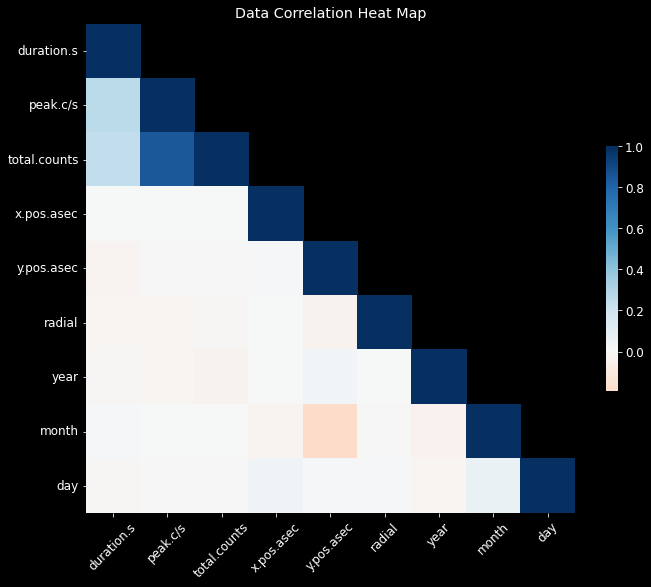

In [ ]:
# Mask to cover the symmetric portion of the heat map
corr = solar_df.corr()
mask = np.triu(np.ones_like(corr)) - np.eye(corr.shape[0])

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("RdBu", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=0, cbar_kws={"shrink": .5})
plt.title("Data Correlation Heat Map")
plt.xticks(rotation=45)
plt.show()

### Total number of flares grouped by duration

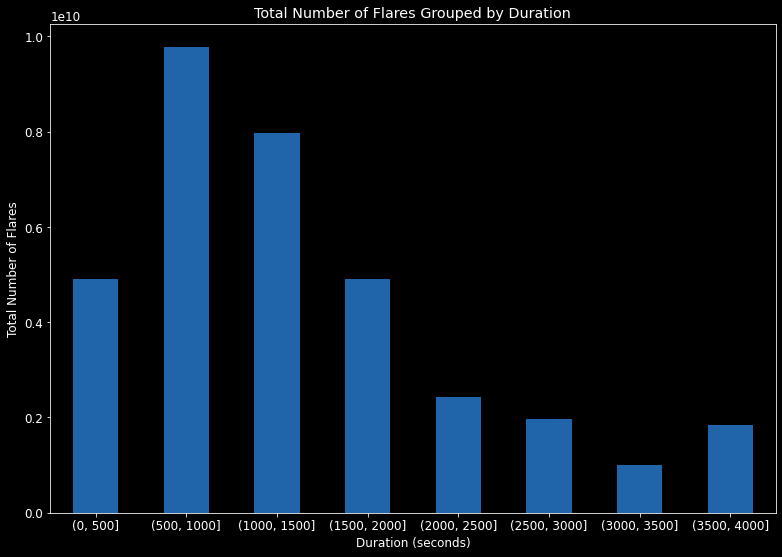

In [ ]:
f, ax = plt.subplots(figsize=(13, 9))
df = solar_df.loc[:, ['duration.s', 'total.counts']]
df_2 = df.groupby(pd.cut(df["duration.s"], range(0, max(duration), 500))).sum()
ax = df_2["total.counts"].plot(kind='bar', title="Total Number of Flares Grouped by Duration", color=color)
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Total Number of Flares")
plt.xticks(rotation=0)
plt.show()

### Frequency of flare events given in a particular duration

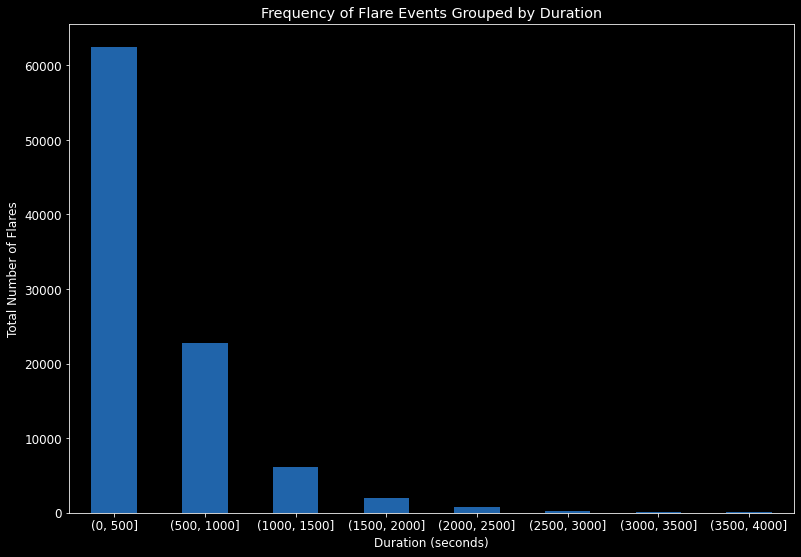

In [ ]:
f, ax = plt.subplots(figsize=(13, 9))
df_2 = df.groupby(pd.cut(df["duration.s"], range(0, max(duration), 500))).count()
ax = df_2["total.counts"].plot(kind='bar', title="Frequency of Flare Events Grouped by Duration", color=color)
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Total Number of Flares")
plt.xticks(rotation=0)
plt.show()

### Mean Number of Flares in the given duration

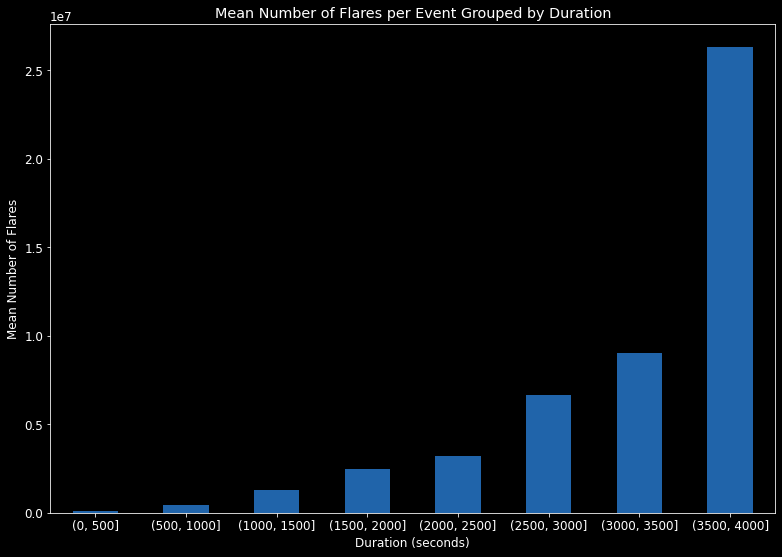

In [ ]:
f, ax = plt.subplots(figsize=(13, 9))
df_2 = df.groupby(pd.cut(df["duration.s"], range(0, max(duration), 500))).mean()
ax = df_2["total.counts"].plot(kind='bar', title="Mean Number of Flares per Event Grouped by Duration", color=color)
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Mean Number of Flares")
plt.xticks(rotation=0)
plt.show()

### Number of flare events per year

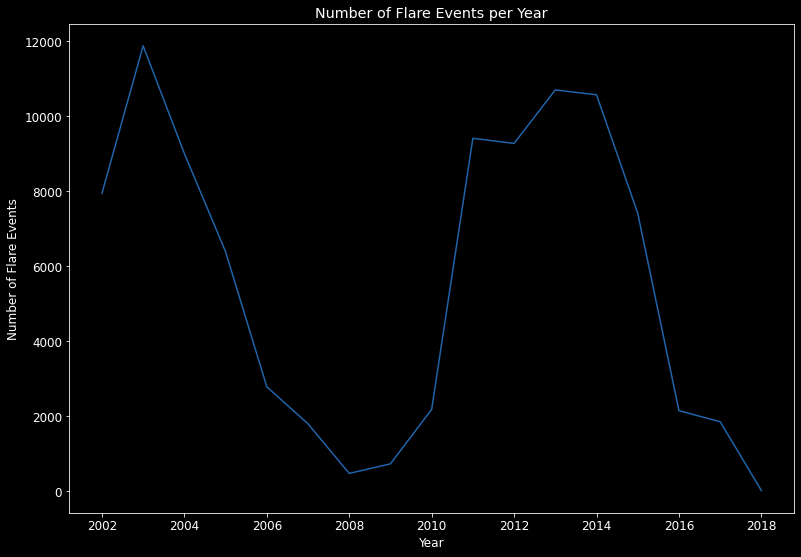

In [ ]:
f, ax = plt.subplots(figsize=(13, 9))
df = solar_df.loc[:, ['year', 'total.counts']]
df = df.groupby(df["year"]).count()
ax = df["total.counts"].plot(title="Number of Flare Events per Year", color=color)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Flare Events")
plt.show()

### Number of flare event across all years per month

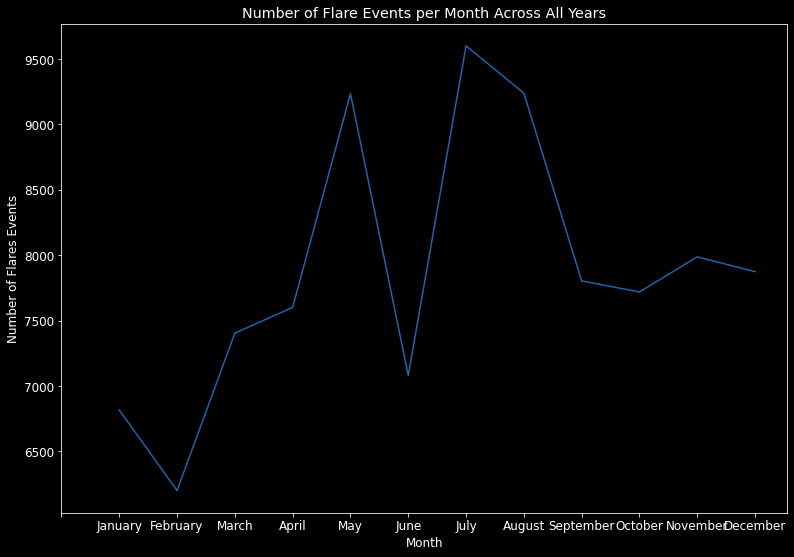

In [ ]:
f, ax = plt.subplots(figsize=(13, 9))
df = solar_df.loc[:, ['month', 'total.counts']]
df = df["total.counts"].groupby(df["month"]).count()
ax = df.plot(title="Number of Flare Events per Month Across All Years", color=color)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Flares Events")
plt.xticks(range(13), month_order)
plt.show()

### Energy Band vs Radial Distance

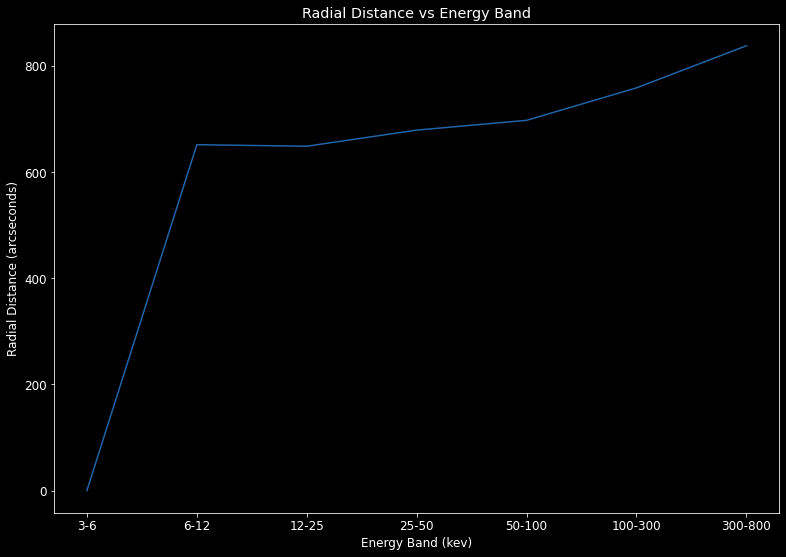

In [ ]:
f, ax = plt.subplots(figsize=(13, 9))
df = solar_df.loc[:, ['energy.kev', 'radial']]
df = df[df['energy.kev'] != "800-7000"]
df = df[df['energy.kev'] != "7000-20000"]
df = df.groupby(['energy.kev'])['radial'].mean()
ax = df.plot(title="Radial Distance vs Energy Band", color=color)
ax.set_xlabel("Energy Band (kev)")
ax.set_ylabel("Radial Distance (arcseconds)")
plt.show()

### Energy Band vs Duration

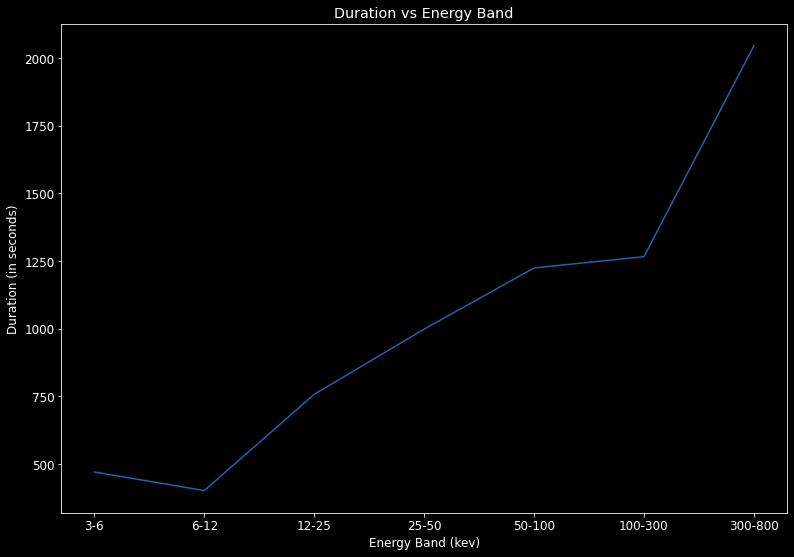

In [ ]:
f, ax = plt.subplots(figsize=(13, 9))
df = solar_df.loc[:, ['energy.kev', 'duration.s']]
df = df[df['energy.kev'] != "800-7000"]
df = df[df['energy.kev'] != "7000-20000"]
df = df.groupby(['energy.kev'])['duration.s'].mean()
ax = df.plot(title="Duration vs Energy Band", color=color)
ax.set_xlabel("Energy Band (kev)")
ax.set_ylabel("Duration (in seconds)")
plt.show()

### Radial Distance vs Year

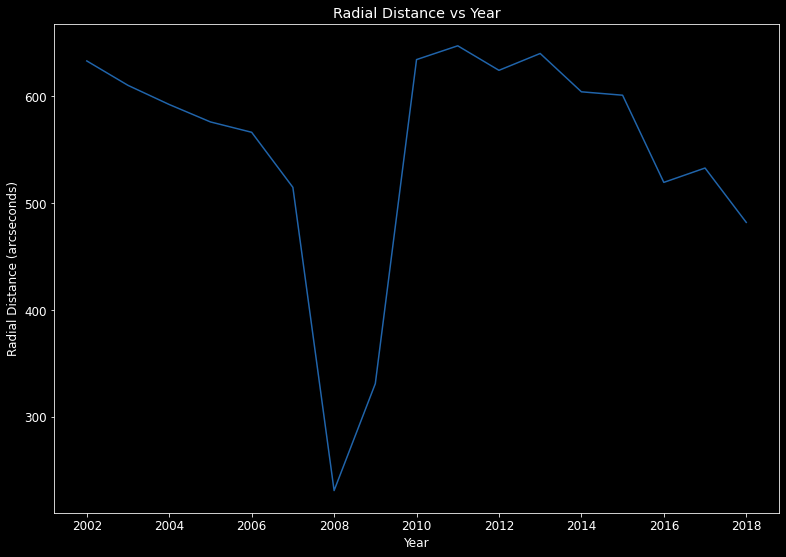

In [ ]:
f, ax = plt.subplots(figsize=(13, 9))
df = solar_df.loc[:, ['year', 'radial']]
df = df.groupby(['year'])['radial'].mean()
ax = df.plot(title="Radial Distance vs Year", color=color)
ax.set_xlabel("Year")
ax.set_ylabel("Radial Distance (arcseconds)")
plt.show()

# Machine Learning

In [ ]:
pd_df = pd_df.rename(columns={'duration.s': 'duration', 'peak.c/s': 'peak_c_s', 'total.counts': 'total_counts', 
                                    'energy.kev': 'energy_kev', 'x.pos.asec': 'x_pos', 'y.pos.asec': 'y_pos', 
                                    'dt.start': 'date_start', 'dt.peak':'date_peak', 'dt.end': 'date_end'})

In [ ]:
pd_df.head(5)

,duration,peak_c_s,total_counts,energy_kev,x_pos,y_pos,radial,date_start,date_peak,date_end,year,month,day
flare,,,,,,,,,,,,,
2021213,712,136,167304.0,12-25,592,-358,692,2002-02-12 21:29:56,2002-02-12 21:33:38,2002-02-12 21:41:48,2002,2,12
2021228,288,7,9504.0,6-12,604,-341,694,2002-02-12 21:44:08,2002-02-12 21:45:06,2002-02-12 21:48:56,2002,2,12
2021332,216,15,11448.0,6-12,-310,375,487,2002-02-13 00:53:24,2002-02-13 00:54:54,2002-02-13 00:57:00,2002,2,13
2021308,244,20,17400.0,12-25,-277,378,469,2002-02-13 04:22:52,2002-02-13 04:23:50,2002-02-13 04:26:56,2002,2,13
2021310,236,336,313392.0,25-50,-272,390,476,2002-02-13 07:03:52,2002-02-13 07:05:14,2002-02-13 07:07:48,2002,2,13


In [ ]:
# Enumerating energy range values from str to category
category = {'3-6': 0, '6-12': 1, '12-25': 2, '25-50': 3, '50-100': 4, '100-300': 5, '300-800': 6, '800-7000': 7, '7000-20000': 8}
pd_df['energy_kev'] = pd_df['energy_kev'].map(category)

In [ ]:
# Deal with the skewed duration data using log transform
pd_df['duration'] = np.log1p(pd_df['duration'])

In [ ]:
pd_df = pd_df.drop(['date_start', 'date_peak', 'date_end'], axis=1)

### Create Train/Test Set

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test = train_test_split(pd_df, test_size=0.2)

In [ ]:
X_train.shape, X_test.shape

((75647, 10), (18912, 10))

### Predcition for energy_kev
Best result - Random Forest 0.87

In [ ]:
y_train_energy = X_train['energy_kev']
X_train_energy = X_train.drop(['energy_kev', 'duration'], axis=1)

y_test_energy = X_test['energy_kev']
X_test_energy = X_test.drop(['energy_kev', 'duration'], axis=1)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest_classifier = RandomForestClassifier(n_jobs=-1).fit(X_train_energy, y_train_energy)
random_forest_score = random_forest_classifier.score(X_test_energy, y_test_energy)
random_forest_score_train = random_forest_classifier.score(X_train_energy, y_train_energy)
random_forest_score, random_forest_score_train

(0.8686548223350253, 0.9999735614102344)

### Prediction for duration
Best result - Random Forest 0.8496

In [ ]:
y_train_duration = X_train['duration']
X_train_duration = X_train.drop(['energy_kev', 'duration'], axis=1)

y_test_duration = X_test['duration']
X_test_duration = X_test.drop(['energy_kev', 'duration'], axis=1)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
random_forest_regressor = RandomForestRegressor(n_jobs=-1).fit(X_train_duration, y_train_duration)
random_forest_predictions = random_forest_regressor.predict(X_train_duration)
random_forest_predictions_test = random_forest_regressor.predict(X_test_duration)
random_forest_MSE_train = mean_squared_error(y_train_duration, random_forest_predictions)
random_forest_MSE = mean_squared_error(y_test_duration, random_forest_predictions_test)

random_forest_score = random_forest_regressor.score(X_test_duration, y_test_duration)
random_forest_score_train = random_forest_regressor.score(X_train_duration, y_train_duration)
random_forest_score, random_forest_score_train, random_forest_MSE, random_forest_MSE_train

(0.8455543644863435,
 0.9782757767844703,
 0.11010360733002275,
 0.015161059255677307)

### Prediction for x.pos
Best result - Random Forest 0.69

In [ ]:
y_train_xpos = X_train['x_pos']
X_train_xpos = X_train.drop(['x_pos', 'y_pos'], axis=1)

y_test_xpos = X_test['x_pos']
X_test_xpos = X_test.drop(['x_pos', 'y_pos'], axis=1)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
random_forest_regressor = RandomForestRegressor(n_jobs=-1).fit(X_train_xpos, y_train_xpos)
random_forest_predictions = random_forest_regressor.predict(X_test_xpos)
random_forest_score = random_forest_regressor.score(X_test_xpos, y_test_xpos)
random_forest_score_train = random_forest_regressor.score(X_train_xpos, y_train_xpos)
random_forest_score, random_forest_score_train

(0.6960875247464864, 0.9569849950879823)

### Prediction for y.pos
Best result - Random Forest 0.6355

In [ ]:
y_train_ypos = X_train['y_pos']
X_train_ypos = X_train.drop(['x_pos', 'y_pos'], axis=1)

y_test_ypos = X_test['y_pos']
X_test_ypos = X_test.drop(['x_pos', 'y_pos'], axis=1)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
random_forest_regressor = RandomForestRegressor(n_jobs=-1).fit(X_train_ypos, y_train_ypos)
random_forest_predictions = random_forest_regressor.predict(X_test_ypos)
random_forest_score = random_forest_regressor.score(X_test_ypos, y_test_ypos)
random_forest_score_train = random_forest_regressor.score(X_train_ypos, y_train_ypos)
random_forest_score, random_forest_score_train

(0.6731553692155867, 0.9536577720586823)